#### Training a set of models fot different input parameters.

Import library

In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 12.0, 8.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize
from root_numpy import tree2array,array2tree,array2root
import ROOT

import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Concatenate, Dense, Activation, Reshape, Conv1D , Conv2D, MaxPooling1D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Embedding, LSTM

Welcome to JupyROOT 6.10/02


Using TensorFlow backend.


CPU times: user 3.87 s, sys: 877 ms, total: 4.75 s
Wall time: 5.69 s


### import data: create a generator to fit

redesign custom generator, give 3 different inputs

In [2]:
%time
training_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2

def reader_pmt(path):
    extra = np.arange(4096, 4480)
    x_file = ROOT.TFile(path)
    x_tree = x_file.Get("tree")
    x_pmtall = tree2array(x_tree, branches="PMTALL")
    x = np.delete(x_pmtall, extra, axis=1)
    return x

def reader_para(path,para1,para2,para3,para4,para5,para6,para7,para8,para9):
    x_file =  ROOT.TFile(path)
    x_tree = x_file.Get("tree")
    x1 = np.expand_dims(tree2array(x_tree, branches=para1 ),axis=1)
    x2 = tree2array(x_tree, branches=para2 )
    x3 = tree2array(x_tree, branches=para3 )
    x4 = tree2array(x_tree, branches=para4 )
    x5 = tree2array(x_tree, branches=para5 )
    x6 = tree2array(x_tree, branches=para6 )
    x7 = tree2array(x_tree, branches=para7 )
    x8 = tree2array(x_tree, branches=para8 )
    x9 = tree2array(x_tree, branches=para9 )
#     x10 = tree2array(x_tree, branches=para10 )
    
    x = np.stack((x1[:,0],x2[:,1],x3[:,0],x3[:,1],x3[:,2],x3[:,3],x4[:,1],x4[:,7],x4[:,13],x4[:,22],x5[:,33],x5[:,36],x6[:,0],x7[:,1],x8,x9),axis=-1)
    return x

def label(q,k):
    x = np.zeros(len(q))
    for i in range(len(q)):
        x[i] = k
    return x

def sep(q,k,z):
    y = label(q,k)
    x1, x2 ,x3 = np.split(q,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    y1, y2 ,y3 = np.split(y,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    if z == 0:
        return x1, y1
    if z == 1:
        return x2, y2
    if z == 2:
        return x3, y3
    
def comb(one,two,three,four,five,portion):
    one1,one2 = sep(one,0,portion)
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,2,portion)
    four1,four2 = sep(four,3,portion)
    five1,five2 = sep(five,4,portion)
#     six1,six2 = sep(six,5,portion)
#     seven1,seven2 = sep(seven,6,portion)
    
    z = np.concatenate((one1,two1,three1,four1,five1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2),axis=0)
    return z, y

def comb5(one,two,three,four,five,portion):
    one1,one2 = sep(one,0,portion)    
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,2,portion)
    four1,four2 = sep(four,3,portion)
    five1,five2 = sep(five,4,portion)
    
    z = np.concatenate((one1,two1,three1,four1,five1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2),axis=0)
    return z, y

import random
from sklearn.preprocessing import normalize

classes = 7
group = 5

def generator(x):
    while 1:
        alpha = reader_pmt("Alpha.root")
#         bad1 = reader_pmt("BAD_DATA_QUALITY_1.root")
#         bad2 = reader_pmt("BAD_DATA_QUALITY_2.root")
        piled = reader_pmt("Piled_2.root")
        ls = reader_pmt("LS.root")
        lsbeta = reader_pmt("lsbeta.root")
        ref = reader_pmt("RefPulse009.root")
        
        z1, z2 = comb(piled,ref,alpha,ls,lsbeta,x)
        s = np.random.permutation(np.arange(len(z2)))
        z1 = z1[s]
        z2 = z2[s]
        z1_n = normalize(z1, norm="l1")
#         print(len(z1))

        Ratio4us_piled = reader_para("Piled_2.root","Ratio4us","Energy","DataQuality","PSDPara","TriggerCounter","CrystalN","Position_wm","Ratio","TimingDiff")
        Ratio4us_alpha = reader_para("Alpha.root","Ratio4us","Energy","DataQuality","PSDPara","TriggerCounter","CrystalN","Position_wm","Ratio","TimingDiff")
        Ratio4us_ls = reader_para("LS.root","Ratio4us","Energy","DataQuality","PSDPara","TriggerCounter","CrystalN","Position_wm","Ratio","TimingDiff")
        Ratio4us_lsbeta = reader_para("lsbeta.root","Ratio4us","Energy","DataQuality","PSDPara","TriggerCounter","CrystalN","Position_wm","Ratio","TimingDiff")
        Ratio4us_ref = reader_para("RefPulse009.root","Ratio4us","Energy","DataQuality","PSDPara","TriggerCounter","CrystalN","Position_wm","Ratio","TimingDiff")
        
        z3, z4 = comb5(Ratio4us_piled,Ratio4us_ref,Ratio4us_alpha,Ratio4us_ls,Ratio4us_lsbeta,x)
        
#         s2 = np.random.permutation(np.arange(len(z4)))
        
        z3 = z3[s] 
        z4 = z4[s]

        gasf = GASF(image_size=128, overlapping=False, scale='-1')
        
        for i in range(len(z2)):
#             if waveform == "waveform":
                p = np.expand_dims(z1[i],axis=0)
                p = gasf.transform(p)
                q = keras.utils.to_categorical(z2[i],classes)
                r = np.expand_dims(z1_n[i],axis=0)
                s = np.expand_dims(z3[i],axis=0)
                yield [r,p,s],q
                
#             if waveform == "waveform_1d":
#                 p = np.expand_dims(z1_n[i],axis=0)
#                 q = keras.utils.to_categorical(z2[i],classes)
#                 yield(p,q)
        
#         for i in range(len(z3)):
#             if waveform == "parameters":
#                 p = np.expand_dims(z3[i],axis=0)
#                 q = keras.utils.to_categorical(z4[i],group)
#                 yield(p,q)
        
# test = generator(0,"waveform")
# print(next(test)[0].shape)
test = generator(1)
print(next(test)[0][0].shape)
test = generator(0)
# print(next(test).shape)
print(next(test)[1].shape)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.82 µs
(1, 4096)
(1, 7)


### define the model

In [3]:
def multiple_inputs():
    feeder_1d = Input(shape=(4096,))
    model1 = Reshape((4096,1),input_shape=(4096,))(feeder_1d)
    model1 = Conv1D(4, kernel_size=2, strides=4)(model1)
    model1 = MaxPooling1D(pool_size=2)(model1)
    model1 = Activation("relu")(model1)
    model1 = Conv1D(8, kernel_size=2, strides=4)(model1)
    model1 = MaxPooling1D(pool_size=2)(model1)
    model1 = Activation("relu")(model1)
    model1 = Flatten()(model1)
    model1 = Dense(128,activation="relu")(model1)
    model1 = Dropout(0.2)(model1)
    model1 = Dense(64,activation="relu")(model1)
    model1 = Dropout(0.2)(model1)
    waveform_1d_out = Dense(7,activation="sigmoid")(model1)
    
    feeder_2d = Input(shape=(128,128))
    model2 = Reshape((128,128,1),input_shape=(128,128))(feeder_2d)
    model2 = Conv2D(2, kernel_size=1)(model2)
    model2 = MaxPooling2D(pool_size=2)(model2)
    model2 = Activation("relu")(model2)
    model2 = Conv2D(4, kernel_size=1,strides=2)(model2)
    model2 = MaxPooling2D(pool_size=2)(model2)
    model2 = Activation("relu")(model2)
    model2 = Dropout(0.2)(model2)
    model2 = Flatten()(model2)
    model2 = Dense(256,activation="relu")(model2)
    model2 = Dropout(0.3)(model2)
    model2 = Dense(128,activation="relu")(model2)
    model2 = Dropout(0.3)(model2)
#     model2 = Dense(64,activation="relu")(model2)
#     model2 = Dropout(0.3)(model2)
    waveform_2d_out = Dense(7,activation="sigmoid")(model2)
    
    feeder_para = Input(shape=(16,))
    model3 = Dense(64,activation="relu",input_shape=(16,))(feeder_para)
    model3 = Dropout(0.2)(model3)
    model3 = Dense(64,activation="relu")(model3)
    model3 = Dropout(0.2)(model3)
#     model3 = Dense(128,activation="relu")(model3)
#     model3 = Dropout(0.2)(model3)
    para_dense = Dense(7,activation="sigmoid")(model3)
    
    x = keras.layers.concatenate([waveform_1d_out, waveform_2d_out, para_dense])
    x = Dense(256,activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(256,activation="relu")(x)
    x = Dropout(0.2)(x)
    main_output = Dense(7, activation='softmax', name='main_output')(x)
    
    model = Model(inputs=[feeder_1d,feeder_2d,feeder_para],outputs=[main_output])
    model.summary()
    
    return model

mult = multiple_inputs()
mult.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 128, 128)      0                                            
____________________________________________________________________________________________________
input_1 (InputLayer)             (None, 4096)          0                                            
____________________________________________________________________________________________________
reshape_2 (Reshape)              (None, 128, 128, 1)   0           input_2[0][0]                    
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 4096, 1)       0           input_1[0][0]                    
___________________________________________________________________________________________

Epoch 1/20
21430/21430 [==============================] - 303s - loss: 0.1092 - acc: 0.9539 - val_loss: 0.0942 - val_acc: 0.9606
Epoch 2/20
21430/21430 [==============================] - 286s - loss: 0.0992 - acc: 0.9578 - val_loss: 0.0867 - val_acc: 0.9664
Epoch 3/20
21430/21430 [==============================] - 286s - loss: 0.1015 - acc: 0.9552 - val_loss: 0.1126 - val_acc: 0.9433
Epoch 4/20
21430/21430 [==============================] - 284s - loss: 0.0982 - acc: 0.9593 - val_loss: 0.0840 - val_acc: 0.9639
Epoch 5/20
21430/21430 [==============================] - 283s - loss: 0.0918 - acc: 0.9602 - val_loss: 0.0691 - val_acc: 0.9750
Epoch 6/20
21430/21430 [==============================] - 285s - loss: 0.0857 - acc: 0.9639 - val_loss: 0.0863 - val_acc: 0.9639
Epoch 7/20
21430/21430 [==============================] - 283s - loss: 0.0877 - acc: 0.9646 - val_loss: 0.0783 - val_acc: 0.9597
Epoch 8/20
21430/21430 [==============================] - 284s - loss: 0.0873 - acc: 0.9675 - val

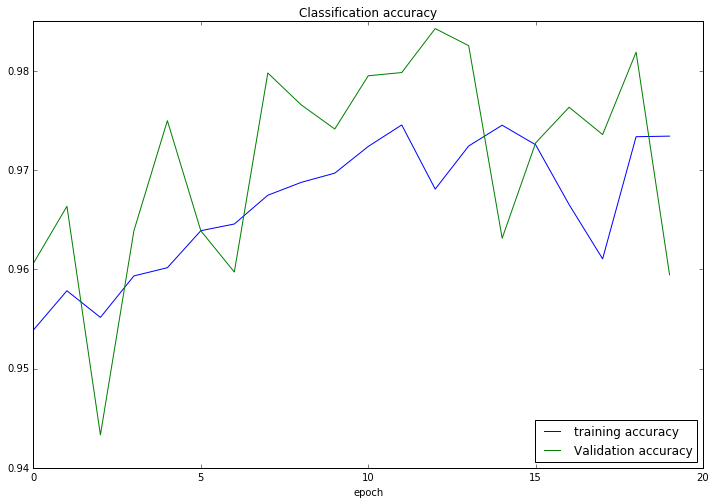

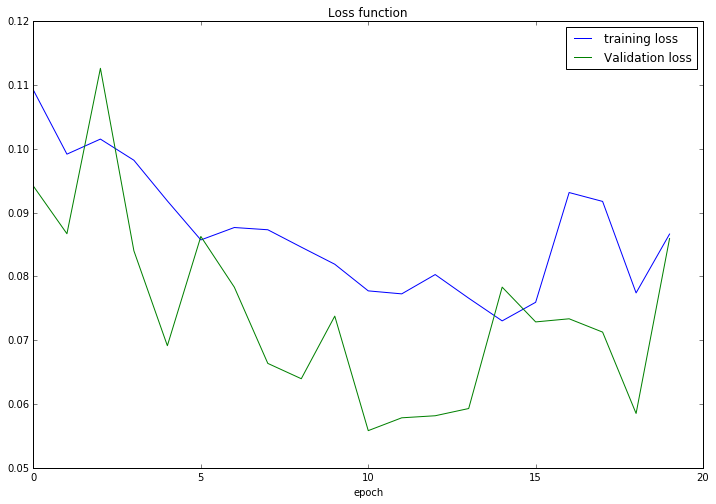

Classification accuracy = 0.959456939992
Test loss: 0.081048282185
Test accuracy: 0.96314267272


2018-02-26 23:38:05.152095: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX


In [4]:
train_gen = generator(0)
val_gen = generator(1)
test_gen = generator(2)

steps_t = 21430
steps_vt = 3062

history = mult.fit_generator(train_gen,steps_per_epoch=steps_t, epochs=20, verbose=1, validation_data=val_gen,validation_steps=steps_vt)
print(history.history.keys())
plt.figure()
plt.title("Classification accuracy")
plt.xlabel("epoch")
plt.plot(history.history['acc'],label="training accuracy")
plt.plot(history.history['val_acc'],label="Validation accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

print("Classification accuracy =",history.history['val_acc'][-1])

mult.save("combined_3_network_modified.h5")

score = mult.evaluate_generator(test_gen,steps=1531)
print('Test loss:', score[0])
print('Test accuracy:', score[1])




In [ ]:
1